In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F

from classes.cube_classes import Cube3State, Cube3
from generate.generate_states import ids_to_color
from utils.random_seed import seed_worker, seed_all, init_weights

torch.set_default_dtype(torch.float64)

import seaborn as sns
import matplotlib.pyplot as plt
import os

In [6]:
for subdir, dirs, files in os.walk('results/'):
    print(subdir)
    for file in files:
        if '00000000' in file:
            filepath = os.path.join(subdir, file)
            first_part, second_part = file.split('_ts')
            first_part += '_ts'
            n1, n2, last_part = second_part.split('.')
            number = round(float(n1 + '.' + n2), 1)
            os.rename(filepath, os.path.join(subdir, first_part + f'{number:0.1f}' + '.' + last_part))

results/
results/.ipynb_checkpoints
results/2moves
results/2moves\FeedForward
results/2moves\ResNet
results/2moves\SymEqNet
results/3moves
results/3moves\FeedForward
results/3moves\ResNet
results/3moves\SymEqNet
results/4moves
results/4moves\FeedForward
results/4moves\ResNet
results/4moves\SymEqNet
results/5moves
results/5moves\FeedForward
results/5moves\ResNet
results/5moves\SymEqNet
results/6moves
results/6moves\FeedForward
results/6moves\ResNet
results/6moves\SymEqNet
results/6moves\SymEqNet_1000_1000
results/6moves\SymEqNet_GATv2
results/6moves\SymEqNet_Generalized
results/6moves\SymEqNet_PNA
results/6moves\SymEqNet_zaloha
results/kociemba
results/kociemba\FeedForward_adv
results/kociemba\ResNet
results/kociemba\ResNet_adv
results/kociemba\SymEqNet


In [7]:
DATASET = '6moves'
# models = ['SymEqNet_100_500', 'SymEqNet_1000_1000', 'ResNet']
# models = ['SymEqNet_1000_1000', 'ResNet']

models = ['SymEqNet', 'SymEqNet_PNA', 'SymEqNet_Generalized', 'SymEqNet_GATv2', 'ResNet', 'FeedForward']

In [8]:
RESULT_FOLDERS = {
    model: f'results/{DATASET}/{model}' for model in models
}

In [9]:
test_sizes = [0.1]  # ,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
configs = [(rnd_seed, test_size) for rnd_seed in range(0, 10) for test_size in test_sizes]

In [10]:
last_train_losses_dict, last_test_losses_dict, mean_train_losses_dict, mean_test_losses_dict, results_train_dict, results_test_dict = \
    {model: {test_size: [] for test_size in test_sizes} for model in models}, {model: {test_size: [] for test_size in test_sizes} for model in models}, {model: {test_size: [] for test_size in test_sizes} for model in models}, {model: {test_size: [] for test_size in test_sizes} for model in models}, {model: {test_size: [] for test_size in test_sizes} for model in models}, {model: {test_size: [] for test_size in test_sizes} for model in models}

for model in models:
    for i, config in enumerate(configs):
        if os.path.isfile(RESULT_FOLDERS[model] + f'/last_train_losses_rs{config[0]}_ts{config[1]:0.1f}.npy'):
            last_train_losses = np.load(RESULT_FOLDERS[model] + f'/last_train_losses_rs{config[0]}_ts{config[1]:0.1f}.npy')
            last_test_losses = np.load(RESULT_FOLDERS[model] + f'/last_test_losses_rs{config[0]}_ts{config[1]:0.1f}.npy')
            mean_train_losses = np.load(RESULT_FOLDERS[model] + f'/mean_train_losses_rs{config[0]}_ts{config[1]:0.1f}.npy')
            mean_test_losses = np.load(RESULT_FOLDERS[model] + f'/mean_test_losses_rs{config[0]}_ts{config[1]:0.1f}.npy')
            results = np.load(RESULT_FOLDERS[model] + f'/results_rs{config[0]}_ts{config[1]:0.1f}.npy')
        else:
            last_train_losses = []
            last_test_losses = []
            mean_train_losses = np.zeros(1000)
            mean_test_losses = np.zeros(1000)
            results = [0, 0]

        last_train_losses_dict[model][config[1]].append(last_train_losses)
        last_test_losses_dict[model][config[1]].append(last_test_losses)
        mean_train_losses_dict[model][config[1]].append(mean_train_losses)
        mean_test_losses_dict[model][config[1]].append(mean_test_losses)
        results_train_dict[model][config[1]].append(results[0])
        results_test_dict[model][config[1]].append(results[1])

In [11]:
for model in models:
    print(f'MODEL {model}')
    for key in results_test_dict[model]:
        mean = np.mean(results_test_dict[model][key])
        std = np.std(results_test_dict[model][key])
        print(f'Test Size {int(key*100)}%: MAE {mean:.4f} +- {std:.4f}')
    print('')

MODEL SymEqNet
Test Size 10%: MAE 0.2006 +- 0.0504

MODEL SymEqNet_PNA
Test Size 10%: MAE 0.1392 +- 0.2847

MODEL SymEqNet_Generalized
Test Size 10%: MAE 0.1527 +- 0.0560

MODEL SymEqNet_GATv2
Test Size 10%: MAE 0.1736 +- 0.0646

MODEL ResNet
Test Size 10%: MAE 0.0517 +- 0.0080

MODEL FeedForward
Test Size 10%: MAE 0.1120 +- 0.0061



In [12]:
model_ls, random_seed_ls, test_size_ls, train_loss_ls, test_loss_ls, epochs = [], [], [], [], [], []
# for model in ['SymEqNet', 'ResNet']:
for model in models:
    for rs, ts in configs:
        for epoch in range(50):
            model_ls.append(model)
            random_seed_ls.append(rs)
            test_size_ls.append(ts)
            train_loss_ls.append(mean_train_losses_dict[model][ts][rs][epoch])
            test_loss_ls.append(mean_test_losses_dict[model][ts][rs][epoch])
            epochs.append(epoch+1)

In [13]:
df = pd.DataFrame({'model': model_ls, 'random_seed': random_seed_ls, 'test_size': test_size_ls, 'train_loss': train_loss_ls, 'test_loss': test_loss_ls, 'epoch': epochs})
print(df[['random_seed', 'train_loss']].groupby('random_seed').last())
df.head()

             train_loss
random_seed            
0              0.108722
1              0.113115
2              0.108845
3              0.103290
4              0.102638
5              0.103079
6              0.102784
7              0.109741
8              0.094759
9              0.113860


,model,random_seed,test_size,train_loss,test_loss,epoch
0,SymEqNet,0,0.1,5.844726,5.844738,1
1,SymEqNet,0,0.1,0.327492,0.237111,2
2,SymEqNet,0,0.1,0.205579,0.232183,3
3,SymEqNet,0,0.1,0.197959,0.224140,4
4,SymEqNet,0,0.1,0.186734,0.286102,5


In [14]:
os.makedirs(f'imgs/convergence/{DATASET}', exist_ok=True)

,model,random_seed,test_size,train_loss,test_loss,epoch
0,SymEqNet,0,0.1,5.844726,5.844738,1
1,SymEqNet,0,0.1,0.327492,0.237111,2
2,SymEqNet,0,0.1,0.205579,0.232183,3
3,SymEqNet,0,0.1,0.197959,0.224140,4
4,SymEqNet,0,0.1,0.186734,0.286102,5


3000


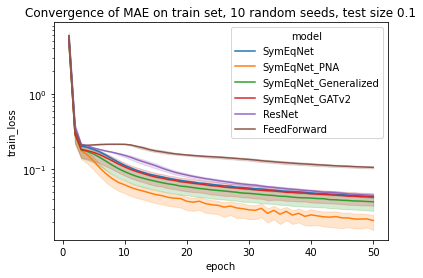

<Figure size 432x288 with 0 Axes>

In [15]:
for test_size in test_sizes:
    df_test_size = df[(df['test_size'] == test_size)] # & (df['epoch'] % 10 == 0)]
    display(df_test_size.head())
    print(len(df_test_size.index))
    sns.lineplot(data=df_test_size, x="epoch", y="train_loss", hue="model")
    plt.title(f'Convergence of MAE on train set, 10 random seeds, test size {test_size:0.1f}')
    plt.yscale('log')
    plt.savefig(f'imgs/convergence/{DATASET}/train/train_conv_testsize_{test_size:0.1f}.png', dpi=100)
    plt.show()
    plt.cla()
    plt.clf()

model          FeedForward
random_seed              9
test_size              0.1
train_loss         0.11386
test_loss         0.119339
epoch                   50
Name: 2999, dtype: object


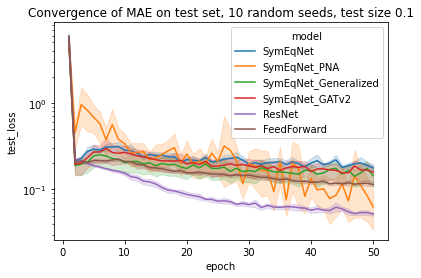

<Figure size 432x288 with 0 Axes>

In [16]:
for test_size in test_sizes:
    df_test_size = df[(df['test_size'] == test_size)]  # & (df['epoch'] % 10 == 0)]
    print(df_test_size.iloc[-1])
    sns.lineplot(data=df_test_size, x="epoch", y="test_loss", hue="model")
    plt.title(f'Convergence of MAE on test set, 10 random seeds, test size {test_size:0.1f}')
    plt.yscale('log')
    plt.savefig(f'imgs/convergence/{DATASET}/test/test_conv_testsize_{test_size:0.1f}.png', dpi=100)
    plt.show()
    plt.cla()
    plt.clf()

model          FeedForward
random_seed              9
test_size              0.1
train_loss         0.11386
test_loss         0.119339
epoch                   50
Name: 2999, dtype: object


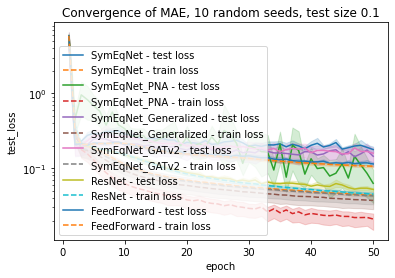

<Figure size 432x288 with 0 Axes>

In [17]:
for test_size in test_sizes:
    df_test_size = df[(df['test_size'] == test_size)] # & (df['epoch'] % 10 == 0)]
    print(df_test_size.iloc[-1])
    for model in models:
        sns.lineplot(data=df_test_size[df_test_size['model'] == model], x="epoch", y="test_loss", label=f"{model} - test loss")
        sns.lineplot(data=df_test_size[df_test_size['model'] == model], x="epoch", y="train_loss", label=f"{model} - train loss", linestyle='--')
    plt.title(f'Convergence of MAE, 10 random seeds, test size {test_size:0.1f}')
    plt.yscale('log')
    plt.savefig(f'imgs/convergence/{DATASET}/train_test_combined/train_test_conv_testsize_{test_size:0.1f}.png', dpi=100)
    plt.show()
    plt.cla()
    plt.clf()

In [18]:
model_ls, means, test_size_ls = [], [], []

# for model in ['SymEqNet', 'ResNet']:
for model in models:
    for rs, ts in configs:
        mean = results_test_dict[model][ts]
#         print(model, mean)
#         print(len(mean))
        model_ls += [model] * len(mean)
        test_size_ls += [ts] * len(mean)
        means += mean
final_maes_df = pd.DataFrame({'final_test_mean': means, 'model': model_ls, 'test_size': test_size_ls})

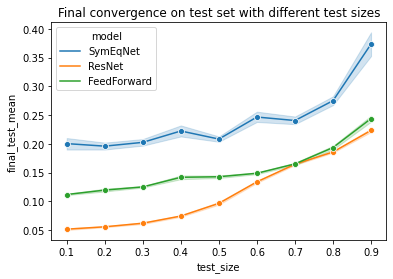

<Figure size 432x288 with 0 Axes>

In [16]:
sns.lineplot(data=final_maes_df, markers=True, x="test_size", y="final_test_mean", hue="model", marker="o")
plt.title(f'Final convergence on test set with different test sizes')
plt.savefig(f'imgs/convergence/{DATASET}/test_conv_per_testsize.png', dpi=100)
plt.show()
plt.cla()
plt.clf()